Libraries used:

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from plyfile import PlyData

from statistics import mean

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from keras.layers import Conv2D, MaxPooling2D
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay, precision_score, recall_score, accuracy_score
from sklearn.preprocessing import StandardScaler

2024-01-04 10:18:24.582461: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-04 10:18:24.610509: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-04 10:18:24.610538: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-04 10:18:24.611237: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-04 10:18:24.616249: I tensorflow/core/platform/cpu_feature_guar

File Configuration

In [2]:
# 'Detection' or 'Classification'
prediction_strategy = 'Detection'

# 'Raw', 'Smoothed' or 'Smoothed and Alligned'
data_prep_stage = 'Smoothed'

# 'Enabled', 'Disabled'
postmodeling_renders = 'Disabled'

Dictionaries

In [3]:
# scans with annotations and, per preparation stage, filepaths
scans = {
    '221111_144114__145900to148050': {
        'Raw':                      'volume/scanData/221111_144114__binary_onlylines145900to148050.ply',
        'Smoothed':                 'volume/scanData/6_flight_vibr_orig_binary.ply',
        'Smoothed and Alligned':    'volume/scanData/6_flight_comp_vibr_binary.ply',
        'Annotations': {
            (280, 560): 3,
            (590, 640): 2,
            (660, 700): 2,
            (740, 810): 2,
            (960, 1010): 2,
            (1140, 1200): 2,
            (1230, 1280): 2,
            (1380, 1400): 2,
            (1450, 1470): 2,
        },
    },
    # '221111_144020__11170to15130': {
    #     'Raw':                      'volume/scanData/221111_144020__binary_onlylines11170to15130raw.ply',
    #     'Smoothed':                 'volume/scanData/221111_144020__binary_onlylines11170to15130smoothedbySLM.ply',
    #     'Smoothed and Alligned':    'volume/scanData/221111_144020__binary_onlylines11170to15130smoothedbySLM_AL.ply',
    #     'Annotations': {
    #         (980, 1020): 2,
    #         (1040, 1080): 2,
    #         (1180, 1220): 2,
    #         (1460, 1500): 2,
    #         (1520, 1580): 2,
    #         (1620, 1860): 3,
    #     },
    # },
    # '221111_144114__40900to45309': {
    #     'Raw':                      'volume/scanData/221111_144020__binary_onlylines40900to45309raw.ply',
    #     'Smoothed':                 'volume/scanData/221111_144020__binary_onlylines40900to45309smoothedbySLM.ply',
    #     'Smoothed and Alligned':    'volume/scanData/221111_144020__binary_onlylines40900to45309smoothedbySLM_AL.ply',
    #     'Annotations': {
    #         (200, 480): 3,
    #         (520, 640): 2,
    #         (660, 720): 2,
    #         (920, 960): 2,
    #         (1000, 1020): 2,
    #         (1100, 1140): 2,
    #         (1180, 1240): 2,
    #         (1500, 1560): 2,
    #     },
    # },
}

# render settings per data preparation stage 
stage_specific_settings = {
    'Raw': {
        'depth': (50, 400),
    },
    'Smoothed': {
        'depth': (-0.5, 0.5),
    },
    'Smoothed and Alligned': {
        'depth': (-0.5, 0.5),
    },
}

# set default settings based on the chosen data preparation stage  
default_settings = stage_specific_settings[data_prep_stage]

Function to get erosion class of a given profile with the offset in scan in mind

In [4]:
def get_erosion_class_based_on_x_coordinate(annotations_dict, x):
    for annotation in annotations_dict.keys():
        if x > annotation[0] and x < annotation[1]:
            if prediction_strategy == 'Detection':
                return 1 
            elif prediction_strategy == 'Classification': 
                return annotations_dict[annotation]
    return 0

Function to make cute annotation lines

In [5]:
def annotation_line(ax, xmin, xmax, y, text, ytext = 0, linecolor = 'red', linewidth = 1, fontsize = 12):
    ax.annotate('',
                xy=(xmin, y),
                xytext=(xmax, y),
                xycoords='data',
                textcoords='data',
                arrowprops={'arrowstyle': '|-|',
                            'color': linecolor, 
                            'linewidth':linewidth
                           }
               )
    
    ax.annotate('', 
                xy=(xmin, y), 
                xytext=(xmax, y), 
                xycoords='data', 
                textcoords='data',
                arrowprops={'arrowstyle': '<->', 
                            'color': linecolor, 
                            'linewidth':linewidth
                           }
               )

    xcenter = xmin + (xmax - xmin) / 2
    
    if ytext == 0:
        ytext = y + (ax.get_ylim()[1] - ax.get_ylim()[0]) / 2

    ax.annotate(text, xy=(xcenter,ytext), ha='center', va='center', fontsize=fontsize)

Save the data from scans alongside the filepaths in the dictionaries. All scans are made to start from 0 on the X axis.

In [6]:
for scan_data in scans.values():
    file = scan_data[data_prep_stage]
    data = PlyData.read(file)

    data['vertex']['x'] -= min(data['vertex']['x'])

    # indices_to_remove = data['vertex']['z'] == 0
    # # https://stackoverflow.com/a/24553551
    # x = np.delete(data['vertex']['x'], indices_to_remove)
    # y = np.delete(data['vertex']['y'], indices_to_remove)
    # z = np.delete(data['vertex']['z'], indices_to_remove)

    # data['vertex']['x'] = x
    # data['vertex']['y'] = y
    # data['vertex']['z'] = z

    scan_data['data'] = data

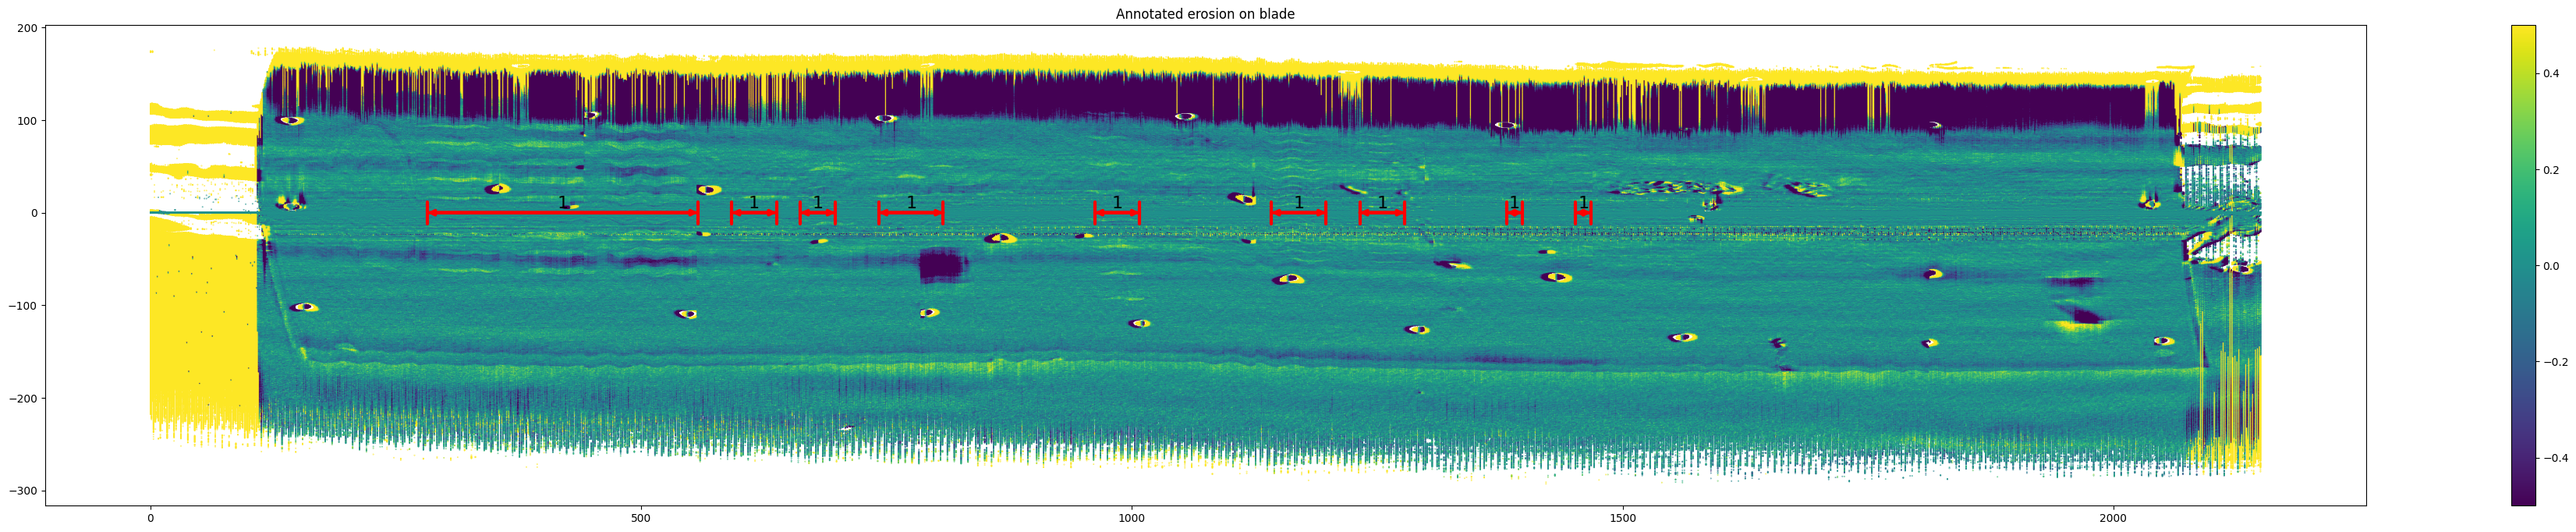

In [7]:
depth_range = default_settings['depth']
figs_and_plots = []
plot_count = 0

for scan_data in scans.values():
    data = scan_data['data']

    x = data['vertex']['x']
    y = data['vertex']['y']
    z = data['vertex']['z']

    # print(len(np.unique(x)))

    figs_and_plots.append(plt.subplots(1, figsize=(48,8)))
    image = figs_and_plots[plot_count][1].scatter(x, y, c=z, s=0.1, vmin=depth_range[0], vmax=depth_range[1])
    figs_and_plots[plot_count][1].title.set_text('Annotated erosion on blade')
    figs_and_plots[plot_count][0].colorbar(image, ax=figs_and_plots[plot_count][1])
    # plt.xticks(
    #     ticks = np.arange(0, len(np.unique(x)), 20), 
    #     labels = list(map(int, np.unique(x)[::20])), 
    #     rotation = 90,
    # )

    for erosion_annotation in scan_data['Annotations'].keys():
        erosion_class = get_erosion_class_based_on_x_coordinate(
            scan_data['Annotations'], 
            erosion_annotation[0] + 1,
        )
        annotation_line(
            ax = figs_and_plots[plot_count][1], 
            text=str(erosion_class), 
            xmin=erosion_annotation[0], 
            xmax=erosion_annotation[1], 
            y=0, 
            ytext=10, 
            linewidth=3, 
            linecolor='red', 
            fontsize=16
        )
    # fig, axs = plt.subplots(1, 3, figsize=(16,9))

    # axs[0].boxplot(x)
    # axs[0].set_title('X Axis')

    # axs[1].boxplot(y)
    # axs[1].set_title('Y Axis')

    # axs[2].boxplot(z)
    # axs[2].set_title('Z Axis')

    plot_count += 1

Function to find an object with most subobjects in a list

In [8]:
def find_max_length_list(l):
    list_len = [len(i) for i in l]
    return max(list_len)


Function to make all items the same length as the longest item in the list by filling it with zeros

In [9]:
def pad_list_to_length_with(a, N, x = 0):
    return a + [x] * (N - len(a))


Function to evaluate predictions of a neural network from a lists of probabilities

In [10]:
def evaluate_predictions(nn_predictions):
    nn_predictions = [np.argmax(pred) for pred in nn_predictions]
    return nn_predictions


Function to render Confusion Matrix and calculate Accuracy, Precision and Recall

In [11]:
def model_scores(test_labels, predicted_labels):
    print("Accuracy is:", accuracy_score(test_labels, predicted_labels))
    print("Accuracy is the ratio of correct True Positives and True negatives,")
    print("This metric is always iffy since in our case it would score almost 40% by always saying that there is no erosion.")
    print()

    print("Precision is:", precision_score(test_labels, predicted_labels, labels=test_labels, average="micro"))
    print("Precision is the ratio of actual True Positives in the predicted Positives,")
    print("In other words: how many items that we predicted to be a class are actually of that class?")
    print()

    print("Recall is:", recall_score(test_labels, predicted_labels, labels=test_labels, average="micro"))
    print("Recall is the ratio of predicted True Positives of all True Positives,")
    print("In other words: how many of all the True Positives did we find?")
    print()

    disp = ConfusionMatrixDisplay.from_predictions(test_labels, predicted_labels)
    disp.ax_.set_title("Predicted values vs actual values of erosion class")


Function to render predictions after modelling

In [12]:
def postmodelling_render(model_type, predictions):
    if postmodeling_renders != "Disabled":
        fig, ax = plt.subplots(1, figsize=(48,8))
        image = ax.scatter(x, y, c=z, s=0.1, vmin=depth_range['top'], vmax=depth_range['bottom'])
        ax.title.set_text(data_prep_stage + ' blade - ' + model_type + ' - Erosion ' + prediction_strategy)
        fig.colorbar(image, ax=ax)
        
        for erosion_annotation in erosion_annotations.keys():

            erosion_class = get_erosion_class_based_on_x_coordinate(erosion_annotation[0] + 1)
            
            annotation_line(
                ax = ax, 
                text='Class ' + str(erosion_class), 
                xmin=erosion_annotation[0], 
                xmax=erosion_annotation[1], 
                y=150, 
                ytext=160, 
                linewidth=3, 
                linecolor='red', 
                fontsize=16
            )
        
        for i in range(len(train_labels_ids)):
            annotation_line(
                ax = ax, 
                text='', 
                xmin=train_labels_ids[i]*11, 
                xmax=train_labels_ids[i]*11 + 10, 
                y=-298, 
                ytext=-280, 
                linewidth=3, 
                linecolor='yellow', 
                fontsize=16
            )
        
        for i in range(len(test_labels)):
            if predictions[i] == test_labels[i]:
                annotation_line(
                    ax = ax, 
                    text=predictions[i], 
                    xmin=test_labels_ids[i]*11, 
                    xmax=test_labels_ids[i]*11 + 10, 
                    y=-298, 
                    ytext=-280, 
                    linewidth=3, 
                    linecolor='green', 
                    fontsize=16
                )
            
            else:
                annotation_line(
                    ax = ax, 
                    text=predictions[i], 
                    xmin=test_labels_ids[i]*11, 
                    xmax=test_labels_ids[i]*11 + 10, 
                    y=-298, 
                    ytext=-280, 
                    linewidth=3, 
                    linecolor='red', 
                    fontsize=16
                )

In [13]:
# patches = len(erosion_annotations)
# patch_plots = tuple([] for _ in range(patches + 1))

# fig, patch_plots = plt.subplots(patches + 1, figsize=(48, patches * 9))

# image = patch_plots[0].scatter(x, y, c=z, s=0.1, vmin=depth_range['top'], vmax=depth_range['bottom'])
# patch_plots[0].title.set_text(data_prep_stage + ' blade')
# fig.colorbar(image, ax=patch_plots[0])

# patch_count = 0
# for erosion_annotation in erosion_annotations.keys():

#     erosion_class = get_erosion_class_based_on_x_coordinate(erosion_annotation[0] + 1)
    
#     annotation_line(
#         ax = patch_plots[0], 
#         text='Class ' + str(erosion_class), 
#         xmin=erosion_annotation[0], 
#         xmax=erosion_annotation[1], 
#         y=150, 
#         ytext=160, 
#         linewidth=3, 
#         linecolor='red', 
#         fontsize=16
#     )

#     patch_count += 1
#     mask = (x > erosion_annotation[0]) & (x < erosion_annotation[1])
#     windowed_x = x[mask]
#     windowed_y = y[mask]
#     windowed_z = z[mask]
#     patch_plots[patch_count].scatter(windowed_x, windowed_y, c=windowed_z, s=0.1, vmin=depth_range['top'], vmax=depth_range['bottom'])
#     patch_plots[patch_count].title.set_text('Class ' +  str(erosion_class) + ' erosion')

Total number of profiles

In [14]:
#len(np.unique(x))

Slicing

In [15]:
max_length_list = 0
for scan_data in scans.values():
    scan_data['slice_start_coordinates'] = []
    scan_data['x_slices'] = []
    scan_data['y_slices'] = []
    scan_data['z_slices'] = []

    current_x = 0

    for xi in np.unique(scan_data['data']['vertex']['x'])[1:]:
        if xi > current_x + 10:
            current_x = xi
            # print(xi)
            scan_data['slice_start_coordinates'].append(xi)

    print("There are", len(scan_data['slice_start_coordinates']), "slices to be made")
    print(scan_data['slice_start_coordinates'])

    stop = scan_data['slice_start_coordinates'][-1]
    current_index = 0

    for coordinate in scan_data['slice_start_coordinates']:
        if coordinate == stop:
            break

        next_coordinate = scan_data['slice_start_coordinates'][current_index + 1]
        mask = (
            (scan_data['data']['vertex']['x'] >= coordinate) &
            (scan_data['data']['vertex']['x'] < next_coordinate)
        )

        scan_data['x_slices'].append(scan_data['data']['vertex']['x'][mask])
        scan_data['y_slices'].append(scan_data['data']['vertex']['y'][mask])
        scan_data['z_slices'].append(scan_data['data']['vertex']['z'][mask])
        
        current_index += 1
    
    max_length_list = max(max_length_list, find_max_length_list(scan_data['z_slices']))
    print(max_length_list)

There are 195 slices to be made
[11.0, 22.0, 33.0, 44.0, 55.0, 66.0, 77.0, 88.0, 99.0, 110.0, 121.0, 132.0, 143.0, 154.0, 165.0, 176.0, 187.0, 198.0, 209.0, 220.0, 231.0, 242.0, 253.0, 264.0, 275.0, 286.0, 297.0, 308.0, 319.0, 330.0, 341.0, 352.0, 363.0, 374.0, 385.0, 396.0, 407.0, 418.0, 429.0, 440.0, 451.0, 462.0, 473.0, 484.0, 495.0, 506.0, 517.0, 528.0, 539.0, 550.0, 561.0, 572.0, 583.0, 594.0, 605.0, 616.0, 627.0, 638.0, 649.0, 660.0, 671.0, 682.0, 693.0, 704.0, 715.0, 726.0, 737.0, 748.0, 759.0, 770.0, 781.0, 792.0, 803.0, 814.0, 825.0, 836.0, 847.0, 858.0, 869.0, 880.0, 891.0, 902.0, 913.0, 924.0, 935.0, 946.0, 957.0, 968.0, 979.0, 990.0, 1001.0, 1012.0, 1023.0, 1034.0, 1045.0, 1056.0, 1067.0, 1078.0, 1089.0, 1100.0, 1111.0, 1122.0, 1133.0, 1144.0, 1155.0, 1166.0, 1177.0, 1188.0, 1199.0, 1210.0, 1221.0, 1232.0, 1243.0, 1254.0, 1265.0, 1276.0, 1287.0, 1298.0, 1309.0, 1320.0, 1331.0, 1342.0, 1353.0, 1364.0, 1375.0, 1386.0, 1397.0, 1408.0, 1419.0, 1430.0, 1441.0, 1452.0, 1463.0, 14

Padding

In [16]:
for scan_data in scans.values():
    scan_data['z_slices_padded'] = []
    for z_slice in scan_data['z_slices']:
        scan_data['z_slices_padded'].append(pad_list_to_length_with(z_slice.tolist(), max_length_list))

Storing mean erosion of each slice as future target for modeling

In [17]:
for scan_data in scans.values():
    scan_data['targets'] = []
    for x_slice in scan_data['x_slices']:
        scan_data['targets'].append(get_erosion_class_based_on_x_coordinate(
            scan_data['Annotations'],
            mean(x_slice),
        ))
    print(scan_data['targets'])

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


Encoding each slice label with the number of that slice

In [18]:
for scan_data in scans.values():
    for i in range(len(scan_data['targets'])):
        scan_data['targets'][i] = scan_data['targets'][i] + i * 10

    print(scan_data['targets'])

[0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200, 210, 220, 230, 240, 251, 261, 271, 281, 291, 301, 311, 321, 331, 341, 351, 361, 371, 381, 391, 401, 411, 421, 431, 441, 451, 461, 471, 481, 491, 500, 510, 520, 531, 541, 551, 561, 570, 580, 591, 601, 611, 621, 630, 640, 650, 661, 671, 681, 691, 701, 711, 721, 730, 740, 750, 760, 770, 780, 790, 800, 810, 820, 830, 840, 850, 861, 871, 881, 891, 901, 910, 920, 930, 940, 950, 960, 970, 980, 990, 1000, 1010, 1020, 1031, 1041, 1051, 1061, 1071, 1080, 1090, 1100, 1111, 1121, 1131, 1141, 1150, 1160, 1170, 1180, 1190, 1200, 1210, 1220, 1230, 1240, 1251, 1260, 1270, 1280, 1290, 1300, 1311, 1321, 1330, 1340, 1350, 1360, 1370, 1380, 1390, 1400, 1410, 1420, 1430, 1440, 1450, 1460, 1470, 1480, 1490, 1500, 1510, 1520, 1530, 1540, 1550, 1560, 1570, 1580, 1590, 1600, 1610, 1620, 1630, 1640, 1650, 1660, 1670, 1680, 1690, 1700, 1710, 1720, 1730, 1740, 1750, 1760, 1770, 1780, 1790, 1800, 1810, 1820, 1830, 1840, 

Merge of slices and tagets

In [19]:
z_slices_padded = []
targets = []
for scan_data in scans.values():
    for slice in scan_data['z_slices_padded']:
        z_slices_padded.append(slice)
    for target in scan_data['targets']:
        targets.append(target)


Splitting the data onto train and test subsets

In [20]:
def data_split():
    global train_data, test_data, train_labels, test_labels
    train_data, test_data, train_labels, test_labels = train_test_split(z_slices_padded, 
                                                                        targets, 
                                                                        test_size=0.33, 
                                                                        #random_state=42
                                                                    )

Isolating slice numbers and labels

In [21]:
def isolate_slice_ids():
    train_labels_ids = np.zeros(len(train_labels), dtype=int)

    for i in range(len(train_labels)):
        train_labels_ids[i] = train_labels[i] / 10
        train_labels[i] = train_labels[i] % 10

    test_labels_ids = np.zeros(len(test_labels), dtype=int)

    for i in range(len(test_labels)):
        test_labels_ids[i] = test_labels[i] / 10
        test_labels[i] = test_labels[i] % 10
    
    return train_labels, test_labels, train_labels_ids, test_labels_ids

Scaling of the data

In [22]:
def scaling():
    # min_max_scaler = MinMaxScaler()
    # min_max_scaler.fit(train_data)
    # train_data = min_max_scaler.transform(train_data)
    # test_data = min_max_scaler.transform(test_data)

    standard_scaler = StandardScaler()
    standard_scaler.fit(train_data)

    global standard_scaled_train_data
    standard_scaled_train_data = standard_scaler.transform(train_data)
    
    global standard_scaled_test_data
    standard_scaled_test_data = standard_scaler.transform(test_data)

    # type(train_data[0][0])

Modeling loop

In [23]:
accuracy_scores = {
    "Zero Benchmark": 0,
    "High Benchmark": 0,
    "Logistic Regression": 0,
    "Support Vector Machine": 0,
    "Random Forest": 0,
    "Sequential Neural Network 1": 0,
    "Sequential Neural Network 2": 0,
    "Convolutional Neural Network 1": 0,
}
modeling_cycles = 4

for i in range(modeling_cycles):
    data_split()
    train_labels, test_labels, train_labels_ids, test_labels_ids = isolate_slice_ids()
    scaling()

    # Zero Benchmark
    zero_benchmark = len(test_labels)*[0]
    accuracy_scores["Zero Benchmark"] += accuracy_score(test_labels, zero_benchmark)
    postmodelling_render('Zero Benchmark', zero_benchmark)

    # High Benchmark
    if prediction_strategy == 'Detection':
        top_class = 1
    elif prediction_strategy == 'Classification':
        top_class = 3
    high_benchmark = len(test_labels)*[top_class]
    accuracy_scores["High Benchmark"] += accuracy_score(test_labels, high_benchmark)
    postmodelling_render('High Benchmark', high_benchmark)

    # Logistic Regression
    lr = LogisticRegression(random_state=0, max_iter=1000).fit(standard_scaled_train_data, train_labels)
    lr_predictions = lr.predict(standard_scaled_test_data)
    accuracy_scores["Logistic Regression"] += accuracy_score(test_labels, lr_predictions)
    postmodelling_render('Logistic Regression', lr_predictions)

    # Support Vector Machine
    svc = svm.SVC(random_state=0, kernel="linear").fit(standard_scaled_train_data, train_labels)
    svc_predictions = svc.predict(standard_scaled_test_data)
    accuracy_scores["Support Vector Machine"] += accuracy_score(test_labels, svc_predictions)
    postmodelling_render('Support Vector Machine', svc_predictions)

    # Random Forest
    rf = RandomForestClassifier().fit(train_data, train_labels)
    rf_predictions = rf.predict(test_data)
    accuracy_scores["Random Forest"] += accuracy_score(test_labels, rf_predictions)
    postmodelling_render('Random Forest', rf_predictions)

    # Sequential Neural Network 1
    model1 = tf.keras.Sequential([
        tf.keras.layers.Dense(512, activation='relu', input_shape=(max_length_list,)),
        tf.keras.layers.Dense(4),
        tf.keras.layers.Softmax()
    ])
    model1.compile(optimizer='adam',
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
        metrics=['accuracy'])
    
    model1.fit(train_data, train_labels, epochs=10)
    nn_predictions1 = model1.predict(test_data)
    nn_predictions1 = evaluate_predictions(nn_predictions1)
    accuracy_scores["Sequential Neural Network 1"] += accuracy_score(test_labels, nn_predictions1)
    postmodelling_render('Sequential Neural Network 1', nn_predictions1)

    # Sequential Neural Network 2
    model2 = tf.keras.Sequential([
        tf.keras.layers.Dense(512, activation='relu', input_shape=(max_length_list,)),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.Softmax()
    ])
    model2.compile(optimizer='adam',
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
        metrics=['accuracy'])
    
    model2.fit(train_data, train_labels, epochs=10)
    nn_predictions2 = model2.predict(test_data)
    nn_predictions2 = evaluate_predictions(nn_predictions2)
    accuracy_scores["Sequential Neural Network 2"] += accuracy_score(test_labels, nn_predictions2)
    postmodelling_render('Sequential Neural Network 2', nn_predictions2)

    # # Convolutional Neural Network 1
    # cmodel1 = tf.keras.Sequential([
    #     tf.keras.layers.Lambda(lambda x: x, input_shape=(max_length_list, 10, )),
    #     tf.keras.layers.Conv2D(32, kernel_size=(3, 3), activation='linear', padding='same'),
    #     tf.keras.layers.Dense(512, activation='relu'),
    #     tf.keras.layers.Dropout(0.5),
    #     tf.keras.layers.Dense(512, activation='relu'),
    #     tf.keras.layers.Dropout(0.5),
    #     tf.keras.layers.Dense(512, activation='relu'),
    #     tf.keras.layers.Dropout(0.5),
    #     tf.keras.layers.Dense(512, activation='relu'),
    #     tf.keras.layers.Softmax()
    # ])
    # cmodel1.compile(optimizer='adam',
    #     loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    #     metrics=['accuracy'])
    
    # cmodel1.fit(train_data, train_labels, epochs=10)
    # cnn_predictions1 = model1.predict(test_data)
    # cnn_predictions1 = evaluate_predictions(cnn_predictions1)
    # accuracy_scores["Convolutional Neural Network 1"] += accuracy_score(test_labels, cnn_predictions1)
    # postmodelling_render('Convolutional Neural Network 1', cnn_predictions1)

for item in accuracy_scores:
    accuracy_scores[item] /= modeling_cycles
    print(item)
    print(accuracy_scores[item])

2024-01-04 10:19:32.995939: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-01-04 10:19:33.000237: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-01-04 10:19:33.000263: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-01-04 10:19:33.003055: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-01-04 10:19:33.003084: I external/local_xla/xla/stream_executor

Epoch 1/10


2024-01-04 10:19:40.178059: I external/local_xla/xla/service/service.cc:168] XLA service 0x7fa1c8b5fcd0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-01-04 10:19:40.178095: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 4060 Laptop GPU, Compute Capability 8.9
2024-01-04 10:19:40.182401: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-01-04 10:19:40.195197: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8906
I0000 00:00:1704363580.242320   83463 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


5/5 [==============================] - 1s 16ms/step - loss: 184.1411 - accuracy: 0.5039
Epoch 2/10
5/5 [==============================] - 0s 13ms/step - loss: 106.3037 - accuracy: 0.7752
Epoch 3/10
5/5 [==============================] - 0s 13ms/step - loss: 177.4402 - accuracy: 0.7364
Epoch 4/10
5/5 [==============================] - 0s 12ms/step - loss: 48.9964 - accuracy: 0.8295
Epoch 5/10
5/5 [==============================] - 0s 13ms/step - loss: 76.6735 - accuracy: 0.7907
Epoch 6/10
5/5 [==============================] - 0s 8ms/step - loss: 13.5982 - accuracy: 0.9225
Epoch 7/10
5/5 [==============================] - 0s 8ms/step - loss: 20.8518 - accuracy: 0.9225
Epoch 8/10
5/5 [==============================] - 0s 9ms/step - loss: 4.2689 - accuracy: 0.9612
Epoch 9/10
5/5 [==============================] - 0s 9ms/step - loss: 4.8639 - accuracy: 0.9612
Epoch 10/10
3/3 [==============================] - 0s 4ms/step
Epoch 1/10
5/5 [==============================] - 1s 16ms/step - loss

Benchmarking

In [ ]:
zero_benchmark = len(test_labels)*[0]
model_scores(test_labels, zero_benchmark)

In [ ]:
postmodelling_render('Zero Benchmark', zero_benchmark)

In [ ]:
if prediction_strategy == 'Detection':
    top_class = 1
elif prediction_strategy == 'Classification':
    top_class = 3

high_benchmark = len(test_labels)*[top_class]
model_scores(test_labels, high_benchmark)

In [ ]:
postmodelling_render('High Benchmark', high_benchmark)

Modeling

Logistic Regression

In [ ]:
lr = LogisticRegression(random_state=0, max_iter=1000).fit(standard_scaled_train_data, train_labels)
lr_predictions = lr.predict(standard_scaled_test_data)

model_scores(test_labels, lr_predictions)

In [ ]:
postmodelling_render('Logistic Regression', lr_predictions)

Support Vector Machine

In [ ]:
svc = svm.SVC(random_state=0, kernel="linear").fit(standard_scaled_train_data, train_labels)
svc_predictions = svc.predict(standard_scaled_test_data)

model_scores(test_labels, svc_predictions)

In [ ]:
postmodelling_render('Support Vector Machine', svc_predictions)

Random Forest

In [ ]:
rf = RandomForestClassifier().fit(train_data, train_labels)
rf_predictions = rf.predict(test_data)

model_scores(test_labels, rf_predictions)

In [ ]:
postmodelling_render('Random Forest', rf_predictions)

Sequential Neural Network

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Dense(512, activation='relu', input_shape=(max_length_list,)),
    tf.keras.layers.Dense(4),
    tf.keras.layers.Softmax()
])

In [ ]:
model.compile(optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy'])

In [ ]:
model.fit(train_data, train_labels, epochs=10)

In [ ]:
nn_predictions = model.predict(test_data)

In [ ]:
nn_predictions = evaluate_predictions(nn_predictions)

In [ ]:
model_scores(test_labels, nn_predictions)

In [ ]:
postmodelling_render('Neural Network', nn_predictions)

Sequential Neural Network

In [ ]:
model2 = tf.keras.Sequential([
    tf.keras.layers.Dense(512, activation='relu', input_shape=(max_length_list,)),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Softmax()
])

In [ ]:
model2.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [ ]:
model2.fit(train_data, train_labels, epochs=200)

In [ ]:
nn_predictions2 = model2.predict(test_data)

In [ ]:
print(nn_predictions2)

In [ ]:
nn_predictions2 = evaluate_predictions(nn_predictions2)

In [ ]:
model_scores(test_labels, nn_predictions2)

In [ ]:
postmodelling_render('Neural Network', nn_predictions2)